In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
#import numpy as np
#from sklearn import metrics
#import math

#import stuff for gradCAM
#import matplotlib.cm as cm
#from IPython.display import Image

#Set GPU to use
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.4.1


In [2]:
#code for GPU mem growth

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [4]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 15, 
                                             restore_best_weights = True)

In [5]:
#build data generators for training and validaton

split = 0.2

df = pd.read_csv('../data/SedMLdata.csv')

# Define dirs and files
train_data_dir = '../data/CropPics'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 8

#set Image size (RGB so imshape is 3)
pix_dim = 1024
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_dataframe(dataframe = df,
                                                    directory = train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'raw',
                                                    x_col = 'CropName',
                                                    y_col = 'D50mm',
                                                    target_size = imsize,
                                                    color_mode = 'rgb',
                                                    subset='training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_dataframe(dataframe=df,
                                                          directory = train_data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = 'D50mm',
                                                          target_size = imsize,
                                                          color_mode = 'rgb',
                                                          subset='validation')

Found 240 validated image filenames.
Found 60 validated image filenames.


In [6]:

total_train = 240
total_val = 60

In [7]:
# define other metrics
#mae_metric = tf.keras.metrics.MeanAbsoluteError(name='mae')

In [8]:
#model

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=imshape),
    layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.GlobalMaxPooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation="linear")
])


model._name="SandCam_CNN"

model.summary()


Model: "SandCam_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1024, 1024, 32)    2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 1024, 32)    128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      

In [12]:
#compile
model.compile(loss='mean_squared_error', 
              optimizer=tf.keras.optimizers.Adam()
             )

In [13]:
#LOSS CURVE

In [14]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 20,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/20
30/30 [==============================] - 22s 500ms/step - loss: 137.4983 - mse: 137.4983 - val_loss: 0.3321 - val_mse: 0.3321
Epoch 2/20
30/30 [==============================] - 16s 541ms/step - loss: 6.0686 - mse: 6.0686 - val_loss: 0.5115 - val_mse: 0.5115
Epoch 3/20
30/30 [==============================] - 17s 577ms/step - loss: 1.7715 - mse: 1.7715 - val_loss: 0.6262 - val_mse: 0.6262
Epoch 4/20
30/30 [==============================] - 17s 565ms/step - loss: 1.5354 - mse: 1.5354 - val_loss: 0.7102 - val_mse: 0.7102
Epoch 5/20
30/30 [==============================] - 18s 580ms/step - loss: 0.5103 - mse: 0.5103 - val_loss: 0.7287 - val_mse: 0.7287
Epoch 6/20
30/30 [==============================] - 18s 598ms/step - loss: 0.3180 - mse: 0.3180 - val_loss: 0.7346 - val_mse: 0.7346
Epoch 7/20
30/30 [==============================] - 18s 595ms/step - loss: 0.3854 - mse: 0.3854 - val_loss: 0.7657 - val_mse: 0.7657
Epoch 8/20
30/30 [==============================] - 18s 611ms/ste

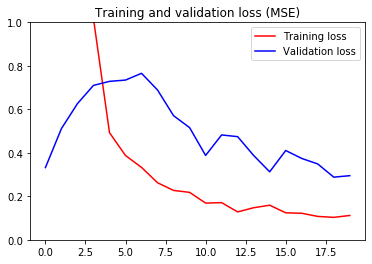

<Figure size 432x288 with 0 Axes>

In [24]:
#look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(mse))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,1)

plt.title('Training and validation loss (MSE)')
plt.legend(loc=0)
plt.figure()
plt.show()


In [ ]:
#save the model
filepath = './models/SNmodel'
model.save(filepath)


In [ ]:
# #model size
# model.save("./models/SNmodel.h5")
# model_file ='./models/SNmodel.h5'
# b = os.path.getsize(model_file)
# print ("Size(mb): %d" % (b/1000000))

In [ ]:
#prune

In [ ]:
#quantize

In [ ]:
#test Quantize